# General Transfer Matrix (GTM) Formalism Scattering

In this example static light scattering simulations are carried out employing a dynamical general transfer matrix formalism which was adapted from [pyGTM](https://pygtm.readthedocs.io).

## Setup

Do all necessary imports and settings.

In [1]:
import udkm1Dsim as ud
u = ud.u  # import the pint unit registry from udkm1Dsim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
u.setup_matplotlib()  # use matplotlib with pint units

## Structure

Refer to the [structure-example](structure.ipynb) for more details.

In this example the sample `Structure` consists of `Layer`s.

In [2]:
layer_air = ud.AmorphousLayer('air', "air", 1*u.um, 0*u.kg/u.m**3)
layer_glass = ud.AmorphousLayer('glass', "glass", 1*u.um, 0*u.kg/u.m**3)
layer_Au = ud.AmorphousLayer('Au', "gold", 50*u.nm, 0*u.kg/u.m**3)

### Set the dielectric function

In [3]:
layer_air.epsilon = 1-0j
layer_glass.epsilon = 1.5**2-0j

In [4]:
def eps_Au(f):
    """
    Gold (Au) permittivity. 

    :param array f: frequency (array or float)
    :return: permittivity (float or len(f)-array)

    **Attention**, two models are used: a simple Drude model with parameters 
    from `Derkachova et al., Plasmonics 11, 941 (2016) (open access) 
    <http://doi.org/10.1007/s11468-015-0128-7>`_ 
    or the tabulated data from Jonhson and Christy 
    (`refractiveindex.info <https://refractiveindex.info/?shelf=main&book=Au&page=Johnson>`_)
    You should check carefully if this works out for you. 
    """
    f = np.array(f)
    import scipy.constants as constants
    c_const = constants.physical_constants['speed of light in vacuum'][0]
    fmin_JC = c_const/1.93e-6
    fmax_JC = c_const/0.188e-6

    #print('Using Jonhson and Christy data for Au')
    epsAufile = './Au_Johnson_nk.csv'
    eps_loaded = np.genfromtxt(epsAufile, delimiter='\t',
                               skip_header=1, unpack=True)

    lbda = eps_loaded[0, :]*1e-6
    n = eps_loaded[1,:]
    k = eps_loaded[2,:]
    eps1 = n**2-k**2
    eps2 = 2*n*k
    floc = c_const/lbda
    epsr = np.interp(f, floc[::-1], eps1[::-1])
    epsi = np.interp(f, floc[::-1], eps2[::-1])

    return epsr+1.0j*epsi

In [5]:
layer_Au.epsilon = eps_Au

In [6]:
S = ud.Structure('Optical Sample')

S.add_sub_structure(layer_air, 1)
S.add_sub_structure(layer_glass, 1)

## Initialize general transfer matrix simulations

The `GTM` class requires a `Structure` object and a boolean `force_recalc` in order overwrite previous simulation results.

These results are saved in the `cache_dir` when `save_data` is enabled.
Printing simulation messages can be en-/disabled using `disp_messages` and progress bars can using the boolean switch `progress_bar`.

In [7]:
gtm = ud.GTM(S, True)
gtm.disp_messages = False
gtm.save_data = False

### set simulation parameters

In [8]:
gtm.wl = np.r_[600]*u.nm #  set two photon energies
gtm.theta =  np.r_[1:80:0.1]*u.deg

do the actual calculations

In [9]:
r, R, t, T = gtm.calculate_r_t()

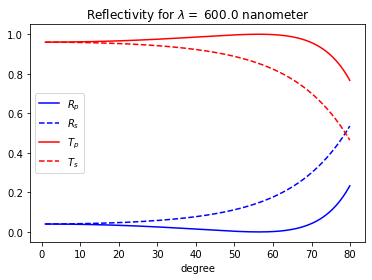

In [10]:
plt.figure()
plt.plot(gtm.theta[0, :], R[0, :, 0], '-b', label=r'$R_p$')
plt.plot(gtm.theta[0, :], R[0, :, 1], '--b', label=r'$R_s$')
plt.plot(gtm.theta[0, :], T[0, :, 0], '-r', label=r'$T_p$')
plt.plot(gtm.theta[0, :], T[0, :, 1], '--r', label=r'$T_s$')
plt.legend()
plt.title('Reflectivity for $\lambda = $ {:0.1f}'.format(gtm.wl[0]))
plt.show()

build new sample

In [11]:
gtm.wl = np.r_[400:800:2]*u.nm #  set two photon energies
gtm.theta = np.linspace(1, 80.0, 100)*u.deg

c:\users\loc_schick\general\git\udkm1dsim\udkm1Dsim\simulations\scattering.py:258: RuntimeWarning: invalid value encountered in arcsin
  self._theta = np.arcsin(np.outer(self._wl, self._qz[0, :])/np.pi/4)


In [12]:
S = ud.Structure('Optical Sample Gold')

S.add_sub_structure(layer_glass, 1)
S.add_sub_structure(layer_Au, 1)
S.add_sub_structure(layer_air, 1)
gtm.S =S

In [13]:
r, R, t, T = gtm.calculate_r_t()

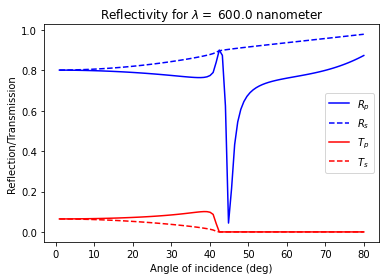

In [14]:
index = 100
plt.figure()
plt.plot(gtm.theta[index, :], R[index, :, 0], '-b', label=r'$R_p$')
plt.plot(gtm.theta[index, :], R[index, :, 1], '--b', label=r'$R_s$')
plt.plot(gtm.theta[index, :], T[index, :, 0], '-r', label=r'$T_p$')
plt.plot(gtm.theta[index, :], T[index, :, 1], '--r', label=r'$T_s$')
plt.legend()
plt.title('Reflectivity for $\lambda = $ {:0.1f}'.format(gtm.wl[index]))
plt.xlabel('Angle of incidence (deg)')
plt.ylabel('Reflection/Transmission')
plt.show()

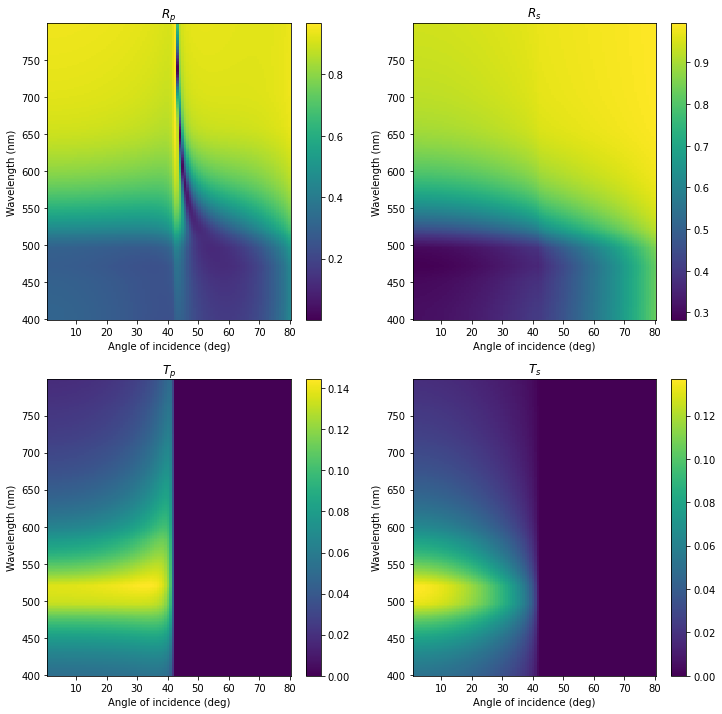

In [15]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.pcolormesh(gtm.theta[0, :].magnitude, gtm.wl.magnitude, R[:, :, 0], shading='auto')
plt.colorbar()
plt.title(r'$R_p$')
plt.xlabel('Angle of incidence (deg)')
plt.ylabel('Wavelength (nm)')

plt.subplot(2,2,2)
plt.pcolormesh(gtm.theta[0, :].magnitude, gtm.wl.magnitude, R[:, :, 1], shading='auto')
plt.colorbar()
plt.title(r'$R_s$')
plt.xlabel('Angle of incidence (deg)')
plt.ylabel('Wavelength (nm)')

plt.subplot(2,2,3)
plt.pcolormesh(gtm.theta[0, :].magnitude, gtm.wl.magnitude, T[:, :, 0], shading='auto')
plt.colorbar()
plt.title(r'$T_p$')
plt.xlabel('Angle of incidence (deg)')
plt.ylabel('Wavelength (nm)')

plt.subplot(2,2,4)
plt.pcolormesh(gtm.theta[0, :].magnitude, gtm.wl.magnitude, T[:, :, 1], shading='auto')
plt.colorbar()
plt.title(r'$T_s$')
plt.xlabel('Angle of incidence (deg)')
plt.ylabel('Wavelength (nm)')

plt.show()

### Electric Field

In [16]:
gtm.wl = np.r_[400:800]*u.nm #  set two photon energies
gtm.theta =  np.r_[45]*u.deg
r, R, t, T = gtm.calculate_r_t()

c:\users\loc_schick\general\git\udkm1dsim\udkm1Dsim\simulations\scattering.py:258: RuntimeWarning: invalid value encountered in arcsin
  self._theta = np.arcsin(np.outer(self._wl, self._qz[0, :])/np.pi/4)


In [17]:
zplot, E_out, H_out, zn_plot = gtm.calculate_Efield(r, R, t, T, dz=1e-9, magnetic=True) # get the electric field

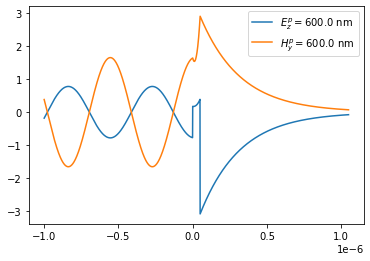

In [18]:
plt.figure()
i = 200
j = 0
plt.plot(zplot, np.real(E_out[i, j, 2, :]), label='$E_z^p=${:0.1f} nm'.format(gtm.wl[i].magnitude))
plt.plot(zplot, np.real(H_out[i, j, 1, :]), label='$H_y^p=${:0.1f} nm'.format(gtm.wl[i].magnitude))

plt.legend()
plt.show()

c:\users\loc_schick\general\python\wpy64-3890\python-3.8.9.amd64\lib\site-packages\matplotlib\cbook\__init__.py:736: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.array(x, subok=True, copy=copy)


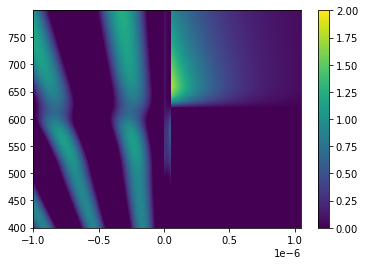

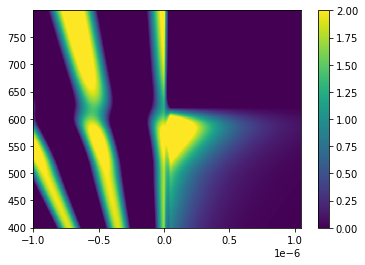

In [19]:
plt.figure()

plt.pcolormesh(zplot, gtm.wl, np.real(E_out[:, 0, 2, :]), vmin=0, vmax=2, shading='auto')
plt.colorbar()

plt.show()

plt.figure()

plt.pcolormesh(zplot, gtm.wl, np.real(H_out[:, 0, 1, :]), vmin=0, vmax=2, shading='auto')
plt.colorbar()

plt.show()

## Air Gap Example

In [20]:
wavenumbers = np.r_[750:1050:1]/u.cm
gtm.wl = 1/wavenumbers  # set the wavelength by wavenumber
gtm.theta =  np.r_[30]*u.deg

c:\users\loc_schick\general\git\udkm1dsim\udkm1Dsim\simulations\scattering.py:258: RuntimeWarning: invalid value encountered in arcsin
  self._theta = np.arcsin(np.outer(self._wl, self._qz[0, :])/np.pi/4)


use pyGTM permittivities

In [21]:
import GTM.Permittivities as perm
eps_KRS5 = perm.eps_KRS5
eps_SiC6Hx = perm.eps_SiC6Hx
eps_SiC6Hz = perm.eps_SiC6Hz

In [22]:
layer_KRS5 = ud.AmorphousLayer('KRS5', "KRS5", 1*u.um, 0*u.kg/u.m**3)
layer_KRS5.epsilon = lambda f: eps_KRS5(f)
layer_SiC6H = ud.AmorphousLayer('SiC6H', "SiC6H", 3*u.um, 0*u.kg/u.m**3)
layer_SiC6H.epsilon = [lambda f: eps_SiC6Hx(f), lambda f: eps_SiC6Hx(f), lambda f: eps_SiC6Hz(f)]
layer_air.thickness = 5.5*u.um

build the sample

In [23]:
S = ud.Structure('Optical Sample Gold')
S.add_sub_structure(layer_KRS5, 1)
S.add_sub_structure(layer_air, 1)
S.add_sub_structure(layer_SiC6H, 1)
gtm.S = S

calculate the reflectivity and transmission

In [24]:
r, R, t, T = gtm.calculate_r_t()

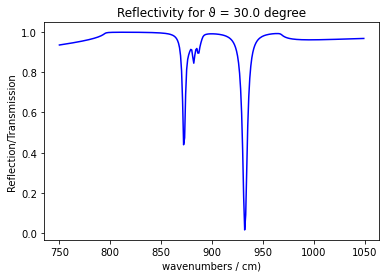

In [25]:
index = 0
plt.figure()
plt.plot(wavenumbers, R[:, index, 0], '-b', label=r'$R_p$')
plt.title('Reflectivity for ϑ = {:0.1f}'.format(gtm.theta[0, index]))
plt.xlabel('wavenumbers / cm)')
plt.ylabel('Reflection/Transmission')
plt.show()

In [26]:
dz = 100e-9 # spatial resolution
zplot, E_out, zn_plot = gtm.calculate_Efield(r, R, t, T, dz=dz)

<ipython-input-27-92fee538baaf>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.axhline(zn_plot[1]*1e6, LineStyle='--')


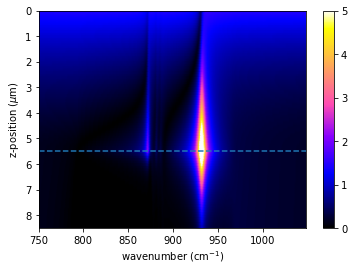

In [27]:
#wnm, zm = np.meshgrid(wavenumbers, zplot*1e6)
fig2ab = plt.figure()

axfield = fig2ab.add_subplot(111)
img = np.abs(E_out[:, 0, 0, :].T)
axc = axfield.pcolormesh(wavenumbers.magnitude, zplot*1e6, img, vmin=0, vmax=5, 
                         shading='gouraud', cmap=plt.cm.gnuplot2)

axfield.invert_yaxis()
axfield.set_xlabel('wavenumber (cm$^{-1}$)')
axfield.set_ylabel('z-position ($\mu$m)')
axfield.set_ylim([8.5, 0])
plt.axhline(zn_plot[1]*1e6, LineStyle='--')
fig2ab.colorbar(axc)

plt.show()

# Multilayer

In [28]:
### Physical constants
c_const = 3e8
eV = 1.6e-19
m0 = 9.11e-31 ## electron rest mass
meff = 0.202*m0
eps0 = 8.854e-12 ## vacuum permittivity
# Import the refractive index of the doped QW
fimp, eps1zz, eps2zz = np.genfromtxt('EpsQW_zz.txt', delimiter='\t',
                                     skip_header=1, unpack=True)
fimp, eps1plane, eps2plane = np.genfromtxt('EpsQW_plane.txt', delimiter='\t',
                                           skip_header=1, unpack=True)

def epsQW_zz(f):
    eps1 = np.interp(f, fimp, eps1zz)
    eps2 = np.interp(f, fimp, eps2zz)
    return eps1+1.0j*eps2


def epsQW_plane(f):
    eps1 = np.interp(f, fimp, eps1plane)
    eps2 = np.interp(f, fimp, eps2plane)
    return eps1+1.0j*eps2


# Doped mirror: a bulky, doped semiconductor layer
DopMirr = 5e20*1e6  # doping in m-3
f_P_mirr = np.sqrt(DopMirr*eV**2/(meff*eps0*5.35))/(2.*np.pi)  # plasma frequency
epsmirr = lambda x: perm.eps_drude(x, f_P_mirr, 1./500e-15, epsinf=5.35)

# Barriers have a permittivity interpolated from their constituents
epsBarrx = lambda x: 0.26*perm.eps_AlNx(x)+perm.eps_GaNx(x)*(1.0-0.26)
epsBarrz = lambda x: 0.26*perm.eps_AlNz(x)+perm.eps_GaNz(x)*(1.0-0.26)

In [29]:
Nqw = 20  # Number of QWs
tQW = 3*u.nm  # thickness of the QW
tBarr = 10.0*u.nm  # Barrier thickness
Lcav = 1*u.um  # total length of the cavity
LAR = Nqw*tQW+(Nqw+1)*tBarr  # length of the active region // superlattice
Lspac = Lcav-LAR  # length of the spacer
tmirr = 0.5*u.um  # mirror thickness

barrier = ud.AmorphousLayer('barrier', "barrier", tBarr, 0*u.kg/u.m**3)
barrier.epsilon = [epsBarrx, epsBarrx, epsBarrz]

QW = ud.AmorphousLayer('qw', "quantum well", tQW, 0*u.kg/u.m**3)
QW.epsilon = [epsQW_plane, epsQW_plane, epsQW_zz]

GaNspacer_sl = ud.AmorphousLayer('GaNspacer_sl', "GaNspacer_sl", Lspac, 0*u.kg/u.m**3)
GaNspacer_sl.epsilon = [perm.eps_GaNx, perm.eps_GaNx, perm.eps_GaNz]

GaNspacer_empty = ud.AmorphousLayer('GaNspacer_empty', "GaNspacer_empty", Lcav, 0*u.kg/u.m**3)
GaNspacer_empty.epsilon = [perm.eps_GaNx, perm.eps_GaNx, perm.eps_GaNz]

mirror = ud.AmorphousLayer('mirror', "mirror", tmirr, 0*u.kg/u.m**3)
mirror.epsilon = epsmirr

superstrate = ud.AmorphousLayer('superstrate', "superstrate", 0.5*u.um, 0*u.kg/u.m**3)
superstrate.epsilon = [perm.eps_GaNx, perm.eps_GaNx, perm.eps_GaNz]

substrate = ud.AmorphousLayer('substrate', "substrate", 200*u.nm, 0*u.kg/u.m**3)
substrate.epsilon = eps_Au

In [30]:
S_empty = ud.Structure('empty')

S_empty.add_sub_structure(superstrate)
S_empty.add_sub_structure(mirror)
S_empty.add_sub_structure(GaNspacer_empty)
S_empty.add_sub_structure(substrate)

S_sl = ud.Structure('SL')
S_sl.add_sub_structure(superstrate)
S_sl.add_sub_structure(mirror)
S_sl.add_sub_structure(GaNspacer_sl)

DL = ud.Structure('DL')
DL.add_sub_structure(barrier)
DL.add_sub_structure(QW)

S_sl.add_sub_structure(DL, Nqw)
S_sl.add_sub_structure(barrier)
S_sl.add_sub_structure(substrate)

In [31]:
gtm = ud.GTM(S_empty, True)
gtm.disp_messages = False
gtm.save_data = False

gtm.wl = np.linspace(4, 11, 100)*u.um  # set two photon energies
gtm.theta = np.r_[1:80:0.5]*u.deg


gtm.S = S_empty
r_empty, R_empty, t_empty, T_empty = gtm.calculate_r_t()
zplot_empty, E_out_empty, H_out_empty, zn_plot_empty = gtm.calculate_Efield(
    r_empty, R_empty, t_empty, T_empty, magnetic=True)
Poy_empty, A_empty = gtm.calculate_Poynting_Absorption_vs_z(
    zplot_empty, E_out_empty, H_out_empty, R_empty)

gtm.S = S_sl
r_sl, R_sl, t_sl, T_sl = gtm.calculate_r_t()
zplot_sl, E_out_sl, H_out_sl, zn_plot_sl = gtm.calculate_Efield(
    r_sl, R_sl, t_sl, T_sl, magnetic=True)
Poy_sl, A_sl = gtm.calculate_Poynting_Absorption_vs_z(
    zplot_sl, E_out_sl, H_out_sl, R_sl)

c:\users\loc_schick\general\python\wpy64-3890\python-3.8.9.amd64\lib\site-packages\matplotlib\cbook\__init__.py:736: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.array(x, subok=True, copy=copy)


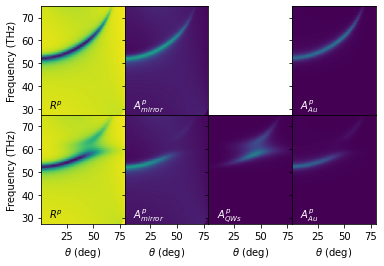

In [32]:
## Interfaces of interest
zmirr = np.abs(zplot_empty*u.m-tmirr).argmin() ## doped mirror
zspac = np.abs(zplot_empty*u.m-(tmirr+Lspac)).argmin() ## spacer
zsl = np.abs(zplot_empty*u.m-(tmirr+Lspac+Nqw*tQW+Nqw*tBarr)).argmin() ## superlattice
zAu = zplot_empty.argmax() ## substrate

import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 4, hspace=0, wspace=0)

fig = plt.figure()

axR_empty = fig.add_subplot(gs[0,0])
axR_empty.pcolormesh(gtm.theta[0, :], gtm.frequency.to('THz'), R_empty[:, :, 0],
                     vmin=0, vmax=1, shading='gouraud')
axR_empty.set_xticklabels([])
axR_empty.set_ylabel('Frequency (THz)')
axR_empty.text(0.1, 0.05, r'$R^p$', transform = axR_empty.transAxes)

axA_mirr_empty = fig.add_subplot(gs[0,1], sharex=axR_empty)
axA_mirr_empty.pcolormesh(gtm.theta[0, :], gtm.frequency.to('THz'),
                          A_empty[:, :, 0, zmirr], vmin=0, vmax=1, shading='gouraud')
axA_mirr_empty.set_yticklabels([])
axA_mirr_empty.text(0.1, 0.05, r'$A^p_{mirror}$', transform = axA_mirr_empty.transAxes,
                    color='w')

axA_Au_empty = fig.add_subplot(gs[0,3], sharex=axR_empty)
axA_Au_empty.pcolormesh(gtm.theta[0, :], gtm.frequency.to('THz'),
                        A_empty[:, :, 0, zAu]-A_empty[:, :, 0, zmirr], vmin=0, vmax=1, shading='gouraud')
axA_Au_empty.set_yticklabels([])
axA_Au_empty.text(0.1, 0.05, r'$A^p_{Au}$', transform = axA_Au_empty.transAxes,
                  color='w')

## Interfaces of interest
zmirr = np.abs(zplot_sl*u.m-tmirr).argmin() ## doped mirror
zspac = np.abs(zplot_sl*u.m-(tmirr+Lspac)).argmin() ## spacer
zsl = np.abs(zplot_sl*u.m-(tmirr+Lspac+Nqw*tQW+Nqw*tBarr)).argmin() ## superlattice
zAu = zplot_sl.argmax() ## substrate

axR_sl = fig.add_subplot(gs[1,0], sharey = axR_empty)
axR_sl.pcolormesh(gtm.theta[0, :], gtm.frequency.to('THz'), R_sl[:, :, 0],
                  vmin=0, vmax=1, shading='gouraud')
axR_sl.set_xlabel(r'$\theta$ (deg)')
axR_sl.set_ylabel('Frequency (THz)')
axR_sl.text(0.1, 0.05, r'$R^p$', transform = axR_sl.transAxes)

axA_mirr_sl = fig.add_subplot(gs[1,1], sharex=axR_sl)
axA_mirr_sl.pcolormesh(gtm.theta[0, :], gtm.frequency.to('THz'),
                       A_sl[:, :, 0, zmirr], vmin=0, vmax=1, shading='gouraud')
axA_mirr_sl.set_xlabel(r'$\theta$ (deg)')
axA_mirr_sl.set_yticklabels([])
axA_mirr_sl.text(0.1, 0.05, r'$A^p_{mirror}$', transform = axA_mirr_sl.transAxes,
                 color='w')

axA_sl_sl = fig.add_subplot(gs[1,2], sharex=axR_sl)
axA_sl_sl.pcolormesh(gtm.theta[0, :], gtm.frequency.to('THz'),
                     A_sl[:, :, 0, zsl]-A_sl[:, :, 0, zmirr], vmin=0, vmax=1, shading='gouraud')
axA_sl_sl.set_yticklabels([])
axA_sl_sl.set_xlabel(r'$\theta$ (deg)')
axA_sl_sl.text(0.1, 0.05, r'$A^p_{QWs}$', transform = axA_sl_sl.transAxes,
               color='w')

axA_Au_sl = fig.add_subplot(gs[1,3], sharex=axR_sl)
axA_Au_sl.pcolormesh(gtm.theta[0, :], gtm.frequency.to('THz'),
                     A_sl[:, :, 0, zAu]-A_sl[:, :, 0, zsl], vmin=0, vmax=1, shading='gouraud')
axA_Au_sl.set_xlabel(r'$\theta$ (deg)')
axA_Au_sl.set_yticklabels([])
axA_Au_sl.text(0.1, 0.05, r'$A^p_{Au}$', transform = axA_Au_sl.transAxes,
               color='w')

plt.show()

# Azimuthal

In [33]:
## Note that Phi in the text is actually Euler angle psi
psi_start, psi_stop, psi_step = 0, 180, 2
psi_v = np.arange(psi_start, psi_stop+psi_step, psi_step)*u.deg
phi = 0.0*u.deg
# the principal vertical axis of the layer is still z so theta=0
theta = 0.0*u.deg

## physical dimensions
displaythick = 10e-6*u.m
tAir = 8e-6*u.m
tMoO3 = 1.2e-6*u.m
tAlN = 1.0e-6*u.m


KRS5 = ud.AmorphousLayer('KRS5', "KRS5", displaythick, 0*u.kg/u.m**3)
KRS5.epsilon = perm.eps_KRS5

SiC = ud.AmorphousLayer('SiC', "SiC", displaythick, 0*u.kg/u.m**3)
SiC.epsilon = [perm.eps_SiCx, perm.eps_SiCx, perm.eps_SiCz]

AirGap = ud.AmorphousLayer('AirGap', "AirGap", tAir, 0*u.kg/u.m**3)

MoO3 = ud.AmorphousLayer('MoO3', "MoO3", tMoO3, 0*u.kg/u.m**3)
MoO3.epsilon = [perm.eps_MoO3x, perm.eps_MoO3y, perm.eps_MoO3z]

AlN = ud.AmorphousLayer('AlN', "AlN", tAlN, 0*u.kg/u.m**3)
AlN.epsilon = [perm.eps_AlNx, perm.eps_AlNx, perm.eps_AlNz]

S = ud.Structure('sample')

S.add_sub_structure(KRS5)
S.add_sub_structure(AirGap)
S.add_sub_structure(MoO3)
S.add_sub_structure(AlN)
S.add_sub_structure(SiC)

gtm = ud.GTM(S, True)
gtm.disp_messages = False
gtm.save_data = False

wavenumbers = np.r_[500:1050:2]/u.cm
gtm.wl = 1/wavenumbers  # set the wavelength by wavenumber
gtm.theta = np.r_[28]*u.deg


R = np.zeros((len(psi_v), len(gtm._frequency)))
A = np.zeros((len(psi_v), len(gtm._frequency), 3))

from tqdm.notebook import trange, tqdm

for jj in trange(len(psi_v)):
    psi = psi_v[jj]
    ## set the layers orientation
    for i in range(S.get_number_of_layers()):
        if i == 0:
            gtm.S.get_layer_handle(i).euler_angles = [theta, phi, 0.0*u.deg]
        else:
            gtm.S.get_layer_handle(i).euler_angles = [theta, phi, psi]
        
    r_loc, R_loc, t_loc, T_loc = gtm.calculate_r_t()
    R[jj, :] = R_loc[:, 0, 0] # p-pol only
    
    zplot, E_out, H_out, zn_plot = gtm.calculate_Efield(
        r_loc, R_loc, t_loc, T_loc, magnetic=True)
    
    zMoO3 = np.abs(zplot*u.m-(tAir+tMoO3)).argmin()
    zAlN = np.abs(zplot*u.m-(tAir+tMoO3+tAlN)).argmin()
    zSiC = np.abs(zplot*u.m-(tAir+tMoO3+tAlN+displaythick)).argmin()
    
    S_loc, A_loc = gtm.calculate_Poynting_Absorption_vs_z(
        zplot, E_out, H_out, R_loc)
    
    A[jj, :, 0] = A_loc[:, 0, 0, zMoO3]
    A[jj, :, 1] = A_loc[:, 0, 0, zAlN]-A_loc[:, 0, 0, zMoO3]
    A[jj, :, 2] = A_loc[:, 0, 0, zSiC]-A_loc[:, 0, 0, zAlN]
        

  0%|          | 0/91 [00:00<?, ?it/s]

c:\users\loc_schick\general\git\udkm1dsim\udkm1Dsim\simulations\scattering.py:815: RuntimeWarning: invalid value encountered in true_divide
  Cp_re1 = np.abs(psi_unsorted[reflmode1[0], reflmode1[1], reflmode1[2], 0])**2/(
c:\users\loc_schick\general\git\udkm1dsim\udkm1Dsim\simulations\scattering.py:818: RuntimeWarning: invalid value encountered in true_divide
  Cp_re2 = np.abs(psi_unsorted[reflmode0[0], reflmode0[1], reflmode0[2], 0])**2/(


<ipython-input-34-b3bc2f66e754>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


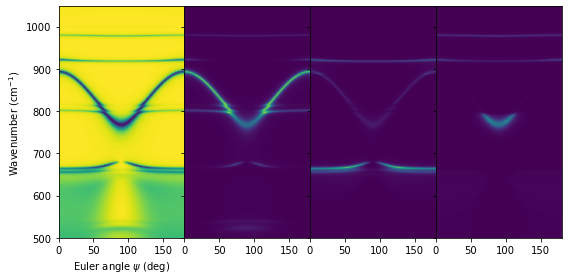

In [34]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1,4, hspace=0, wspace=0)

fig = plt.figure(figsize=(8,4))
axR = fig.add_subplot(gs[0])
axR.pcolormesh(psi_v, (1/gtm.wl).to('1/cm'), R.T, shading='gouraud',
               vmin=0, vmax=1)
axR.set_xlabel('Euler angle $\psi$ (deg)')
axR.set_ylabel('Wavenumber (cm$^{-1}$)')

axA_MoO3 = fig.add_subplot(gs[1])
axA_MoO3.pcolormesh(psi_v, (1/gtm.wl).to('1/cm'), A[:, :, 0].T, shading='gouraud',
                    vmin=0, vmax=1)
axA_MoO3.set_yticklabels([])

axA_AlN = fig.add_subplot(gs[2],sharex = axR, sharey=axA_MoO3)
axA_AlN.pcolormesh(psi_v, (1/gtm.wl).to('1/cm'), A[:, :, 1].T, shading='gouraud',
                   vmin=0, vmax=1)

axA_SiC = fig.add_subplot(gs[3],sharex = axR, sharey=axA_MoO3)
axA_SiC.pcolormesh(psi_v, (1/gtm.wl).to('1/cm'),  A[:, :, 2].T, shading='gouraud',
                   vmin=0, vmax=1)

fig.tight_layout()
fig.show()